### Importing Library###
We will first import the necessary library and define the function needed to preprocess our data

In [3]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
np.random.seed(42)
tf.set_random_seed(42)
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
from numpy import mean
from numpy import std
from numpy import dstack
from numpy import float32,int32
from pandas import read_csv
import pandas as pd
import seaborn as sns
from keras import optimizers
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing

import keras
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import LSTM, Embedding, Flatten, RepeatVector, TimeDistributed, Concatenate, Bidirectional
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import np_utils
from matplotlib import pyplot as plt
%matplotlib inline

# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df
"""The dropna() function is used to remove a row or a column from a dataframe which has a NaN or no values in it. Egs : 
The fillna() function is used to fill the the missing or NaN values in the pandas dataframe with a suitable data 
as decided by the user."""
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan
    
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))
# Load data set containing all the data from csv
df = read_data('WISDM_ar_v1.1_raw.txt')

    
# Define column name of the label vector
LABEL = 'ActivityEncoded'
lables=np.array(LABELS)
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())     
# Differentiate between test set and training set
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]        

# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()

# Round numbers 
#df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})
                             
# Normalize features for test data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()
# Round numbers
#df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})  

def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels


def load_dataset(prefix=''):
    x_train, y_train = create_segments_and_labels(df_train,
                                              80,
                                              40,
                                              LABEL)
    x_test, y_test = create_segments_and_labels(df_test,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

    
    print('X_train shape: ', x_train.shape)
    print(x_train.shape[0], 'training samples')
    print('Y_train shape: ', y_train.shape)
    print('X_test shape: ', x_test.shape)
    print(x_test.shape[0], 'test samples')
    print('Y_test: ', y_test.shape)  
    num_classes = le.classes_.size
    print(list(le.classes_))
    print('X_train shape:', x_train.shape)
    y_train_hot = np_utils.to_categorical(y_train, num_classes)
    print('New Y_train shape: ', y_train_hot.shape)
    print('X_test shape:', x_test.shape)
    y_test_hot = np_utils.to_categorical(y_test, num_classes)
    print('New Y_test shape: ', y_test_hot.shape)
    return x_train, y_train, x_test, y_test, y_train_hot, y_test_hot

# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
    
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

## Training Model##
In this section, we will train the model using the train dataset and test it using the test dataset that we have defined earlier.


In [10]:
X_train, Y_train, X_test, Y_test, Y_train_hot, Y_test_hot = load_dataset()
n_timesteps,n_features,n_outputs=X_train.shape[1],X_train.shape[2],Y_train_hot.shape[1]
n_steps, n_length=1,80
X_train=X_train.reshape((X_train.shape[0],n_steps,n_length,n_features))
X_test=X_test.reshape((X_test.shape[0],n_steps,n_length,n_features))
verbose, epochs, batch_size, validation_split = 1, 30, 80, 0.2
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=100, kernel_size=10, activation='relu'),input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(Conv1D(filters=100, kernel_size=10, activation='relu')))
model.add(TimeDistributed(Conv1D(filters=100, kernel_size=10, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=3)))
model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(LSTM(240)))
model.add(Dropout(0.5))
model.add(Dense(160, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.summary()
adam=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history=model.fit(X_train,Y_train_hot,batch_size=batch_size,epochs=epochs,validation_split=validation_split,shuffle=True,verbose=verbose)


X_train shape:  (20868, 80, 3)
20868 training samples
Y_train shape:  (20868,)
X_test shape:  (6584, 80, 3)
6584 test samples
Y_test:  (6584,)
['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
X_train shape: (20868, 80, 3)
New Y_train shape:  (20868, 6)
X_test shape: (6584, 80, 3)
New Y_test shape:  (6584, 6)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_21 (TimeDis (None, None, 71, 100)     3100      
_________________________________________________________________
time_distributed_22 (TimeDis (None, None, 62, 100)     100100    
_________________________________________________________________
time_distributed_23 (TimeDis (None, None, 53, 100)     100100    
_________________________________________________________________
time_distributed_24 (TimeDis (None, None, 17, 100)     0         
_________________________________________________________________
time_di

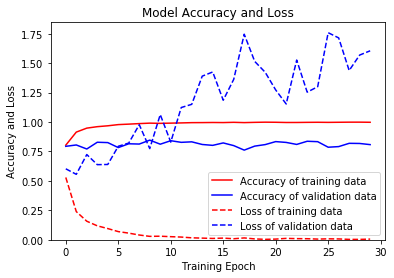

In [11]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

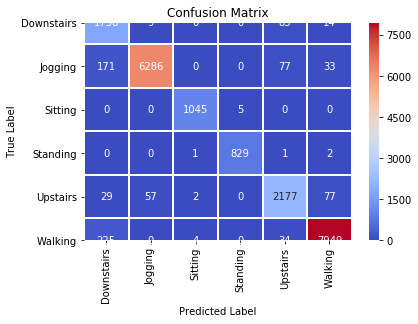

[[1758    9    0    0   83   14]
 [ 171 6286    0    0   77   33]
 [   0    0 1045    5    0    0]
 [   0    0    1  829    1    2]
 [  29   57    2    0 2177   77]
 [ 225    0    4    0   34 7949]]
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1864
           1       0.99      0.96      0.97      6567
           2       0.99      1.00      0.99      1050
           3       0.99      1.00      0.99       833
           4       0.92      0.93      0.92      2342
           5       0.98      0.97      0.98      8212

    accuracy                           0.96     20868
   macro avg       0.95      0.96      0.96     20868
weighted avg       0.96      0.96      0.96     20868



In [12]:
# Print confusion matrix for training data
y_pred_train = model.predict(X_train)
max_y_pred_train = np.argmax(y_pred_train, axis=1)
max_y_train = np.argmax(Y_train_hot,axis=1)
show_confusion_matrix(max_y_train, max_y_pred_train)
cm= metrics.confusion_matrix(max_y_train, max_y_pred_train)
print(cm)
print(classification_report(max_y_train, max_y_pred_train))

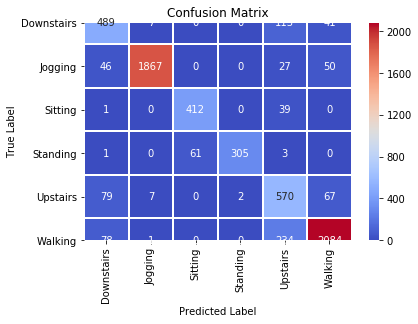

[[ 489    7    0    0  113   41]
 [  46 1867    0    0   27   50]
 [   1    0  412    0   39    0]
 [   1    0   61  305    3    0]
 [  79    7    0    2  570   67]
 [  78    1    0    0  234 2084]]
              precision    recall  f1-score   support

           0       0.70      0.75      0.73       650
           1       0.99      0.94      0.96      1990
           2       0.87      0.91      0.89       452
           3       0.99      0.82      0.90       370
           4       0.58      0.79      0.67       725
           5       0.93      0.87      0.90      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.85      0.84      6584
weighted avg       0.89      0.87      0.88      6584

6584/6584 [==============================] - 13s 2ms/step
0.8698359680059904


In [14]:
# Print confusion matrix for test data
y_pred_test=model.predict(X_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(Y_test_hot, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
cm= metrics.confusion_matrix(max_y_test, max_y_pred_test)
print(cm)
print(classification_report(max_y_test, max_y_pred_test))
#print("predict#################",predict)
_, accuracy = model.evaluate(X_test, Y_test_hot, batch_size=200, verbose=1)
print(accuracy)

In [15]:
model2 = Model(inputs=model.inputs, outputs=model.layers[-3].output)
lstm_output_train= model2.predict(X_train)
print('lstm_output_train: ',lstm_output_train)
lstm_output_test = model2.predict(X_test)
print('lstm_output_test: ',lstm_output_test)

lstm_output_train:  [[ 6.1552275e-02 -6.8516999e-02 -7.4598208e-02 ... -9.2500180e-02
   2.4500206e-02  2.1319116e-02]
 [ 1.8490663e-02  5.4942988e-02  3.0327967e-01 ... -3.0589730e-02
  -4.1055378e-02  9.1479316e-02]
 [ 4.7839156e-04  7.6482251e-02  4.5162559e-01 ... -8.4106661e-02
  -2.8227805e-04  1.2979577e-01]
 ...
 [ 8.6253420e-02 -1.3233098e-01 -1.2469257e-01 ...  4.1734535e-01
  -1.4196861e-01 -2.7801520e-01]
 [ 8.6184643e-02 -1.3070966e-01 -1.2678641e-01 ...  4.1834223e-01
  -1.4006428e-01 -2.7889442e-01]
 [ 8.6261123e-02 -1.3149953e-01 -1.2446667e-01 ...  4.1659337e-01
  -1.4043213e-01 -2.7871379e-01]]
lstm_output_test:  [[ 0.04195116  0.20062236 -0.03967569 ...  0.02736604  0.
   0.5550995 ]
 [-0.2632159   0.4287359  -0.13364057 ...  0.          0.02382161
   0.37806824]
 [-0.17888741  0.47785553 -0.0319985  ...  0.01396795  0.
   0.7227242 ]
 ...
 [ 0.07089511 -0.07862283 -0.02487521 ...  0.09513135 -0.1121401
  -0.27383876]
 [ 0.05988638 -0.08643506 -0.07070183 ...  0.1248

In [16]:
np.savetxt('wisdm_lstm_output_train.csv',lstm_output_train, delimiter=',', fmt='%.7e')
np.savetxt('wisdm_lstm_output_test.csv',lstm_output_test, delimiter=',', fmt='%.7e')

In [17]:
df_lstm_test=pd.DataFrame(lstm_output_test)
df_lstm_train=pd.DataFrame(lstm_output_train)

from sklearn.preprocessing import normalize
normalized_df_lstm_test=pd.DataFrame(normalize(df_lstm_test))
normalized_df_lstm_train=pd.DataFrame(normalize(df_lstm_train))

In [18]:
result_train2=[]
for i in Y_train:
    if i == 0:
        result_train2.append('Downstairs')
    if i == 1:
        result_train2.append('Jogging')
    if i == 2:
        result_train2.append('Sitting')
    if i == 3:
        result_train2.append('Standing')
    if i == 4:
        result_train2.append('Upstairs')
    if i == 5:
        result_train2.append('Walking')
print(result_train2)

['Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging'

In [19]:
result_test2=[]
for i in Y_test:
    if i == 0:
        result_test2.append('Downstairs')
    if i == 1:
        result_test2.append('Jogging')
    if i == 2:
        result_test2.append('Sitting')
    if i == 3:
        result_test2.append('Standing')
    if i == 4:
        result_test2.append('Upstairs')
    if i == 5:
        result_test2.append('Walking')
print(result_test2)

['Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Upstairs', 'Upstairs', 'Upstairs', 'Upstairs', 'Upstairs', 'Upstairs', 'Upstairs', 'Upstairs', 'Upstairs', 'Upstairs', 'Upstairs', 'Upstairs', 'Upstairs', 'Upstairs', 'Upstairs', 'Downstairs', 'Downstairs', 'Downstairs', 'Downstairs', 'Downstairs', 'Downstairs', 'Downstairs', 'Downstairs', 'Downstairs', 'Downstairs', 'Downstairs', 'Downstairs', 'Downstairs', 'Downstairs', 'Downstairs', 'Upstairs', 'Upstairs', 'Upstairs', 'Upstairs', 'Upstairs', 'Upstairs', 'Upstairs', 'Upstairs', 'Upstairs', 'Upstairs', 'Upstairs', 'Upstairs', 'Upstairs', 'Downstairs', 'Downstairs', 'Downstairs', 'Downstairs', 'Downstairs', 'Downstairs', 'Downstairs', 'Downstairs', 'Downstairs', 'Downsta

In [20]:
df_train2=pd.DataFrame(result_train2)
df_test2=pd.DataFrame(result_test2)

In [21]:
merged_lstm_test_file2=pd.concat([normalized_df_lstm_test,df_test2],axis=1)
merged_lstm_train_file2=pd.concat([normalized_df_lstm_train,df_train2],axis=1)

In [22]:
merged_lstm_train_file2

,0,1,2,3,4,5,6,7,8,9,...,471,472,473,474,475,476,477,478,479,0
0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.1,0.2,-0.1,...,-0.1,0.0,0.0,-0.1,0.1,-0.1,-0.0,0.0,0.0,Walking
1,0.0,0.0,0.1,-0.0,-0.1,0.0,0.0,0.0,0.1,0.0,...,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,Walking
2,0.0,0.0,0.1,-0.0,-0.1,0.0,0.0,0.0,0.1,-0.0,...,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,Walking
3,0.0,0.0,0.1,-0.0,-0.1,0.0,0.0,0.0,0.1,-0.0,...,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,Walking
4,0.0,0.0,0.1,-0.0,-0.1,0.0,0.0,0.0,0.1,-0.0,...,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,Walking
5,0.0,0.0,0.1,-0.0,-0.1,0.0,0.0,0.0,0.1,-0.0,...,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,Walking
6,-0.0,0.0,0.1,-0.0,-0.1,0.0,0.0,0.0,0.1,-0.0,...,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,Walking
7,0.0,0.0,0.1,-0.0,-0.1,0.0,0.0,0.0,0.1,-0.0,...,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,Walking
8,-0.0,0.0,0.1,-0.0,-0.1,0.0,0.0,0.1,0.1,-0.0,...,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,Walking
9,-0.0,0.0,0.1,-0.0,-0.1,0.0,0.0,0.0,0.1,-0.0,...,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,Walking


In [23]:
np.savetxt('wisdm_merged_lstm_test_file2.csv',merged_lstm_test_file2, delimiter=',',fmt='%s')
np.savetxt('wisdm_merged_lstm_train_file2.csv',merged_lstm_train_file2, delimiter=',',fmt='%s')